In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch_snippets import *
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data prepration and creating SegData class  

In [14]:
# Define the function that will be used to transform the images

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Define the dataset class (SegData) to fetch input and outpot images for taining phase

In [15]:
import cv2


class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224, 224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')[:,:,0]
        mask = cv2.resize(mask, (224, 224))
        return image, mask
    
    def choose(self): 
        return self[randint(0, len(self))]
    
    def collate(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.tensor(mask[None], dtype=torch.int64) for mask in masks]).to(device)
        return ims, ce_masks

In [16]:
train_data = SegData('train')
val_data = SegData('test')

train_dl = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=train_data.collate)
val_dl = DataLoader(val_data, batch_size=1, shuffle=True, collate_fn=val_data.collate)

In [17]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [18]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(
            *self.encoder[34:]
        )
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x


In [19]:
ce = nn.CrossEntropyLoss()
def UNetloss(y_pred, y_true):
    ce_loss = ce(y_pred, y_true)
    acc = (torch.max(y_pred, 1)[1] == y_true).float().mean()
    return ce_loss, acc

In [20]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [21]:
model = UNet().to(device)

criterion = UNetloss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

c:\Users\LOQ\anaconda3\envs\pytorchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LOQ\anaconda3\envs\pytorchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
model.block2

Sequential(
  (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
)

In [23]:
from torch_snippets.torch_loader import Report
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(bx + 1)/N, train_loss=loss, train_acc=acc, step=epoch, end='\r')
        
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(bx + 1)/N, val_loss=loss, val_acc=acc, step=epoch, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 1.183  val_acc: 0.753  val_loss: 0.985  step: 0.000  train_acc: 0.736  (20.48s - 389.10s remaining)
EPOCH: 2.000  train_loss: 0.693  val_acc: 0.855  val_loss: 0.661  step: 0.990  train_acc: 0.823  (32.62s - 293.56s remaining)
EPOCH: 3.000  train_loss: 0.588  val_acc: 0.816  val_loss: 0.720  step: 1.990  train_acc: 0.842  (44.68s - 253.18s remaining)
EPOCH: 4.000  train_loss: 0.517  val_acc: 0.854  val_loss: 0.558  step: 2.990  train_acc: 0.861  (56.83s - 227.30s remaining)
EPOCH: 5.000  train_loss: 0.465  val_acc: 0.854  val_loss: 0.512  step: 3.990  train_acc: 0.874  (68.98s - 206.94s remaining)
EPOCH: 6.000  train_loss: 0.427  val_acc: 0.863  val_loss: 0.541  step: 4.990  train_acc: 0.882  (81.35s - 189.83s remaining)
EPOCH: 7.000  train_loss: 0.416  val_acc: 0.867  val_loss: 0.462  step: 5.990  train_acc: 0.882  (93.60s - 173.83s remaining)
EPOCH: 8.000  train_loss: 0.385  val_acc: 0.863  val_loss: 0.417  step: 6.990  train_acc: 0.891  (106.01s - 159.02s re

In [24]:
torch.save(model, 'unet_segmentation.pth')

100%|██████████| 121/121 [00:00<00:00, 1161.12it/s]


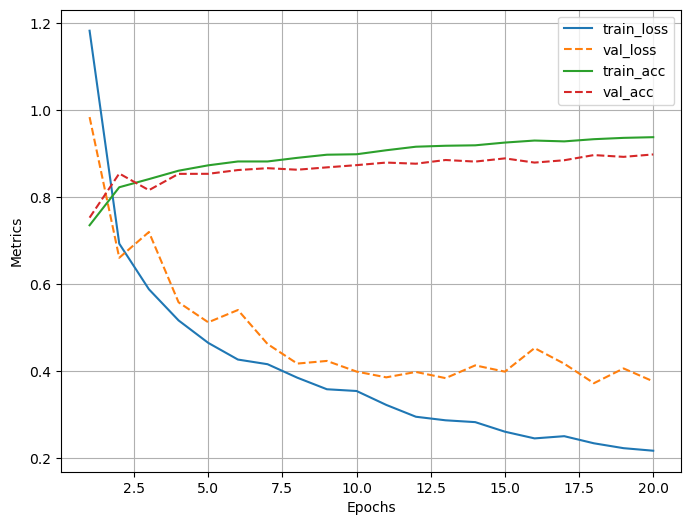

In [26]:
log.plot_epochs(['train_loss', 'val_loss', 'train_acc', 'val_acc'])

In [63]:
# model = torch.load('unet_segmentation.pth', weights_only=False)

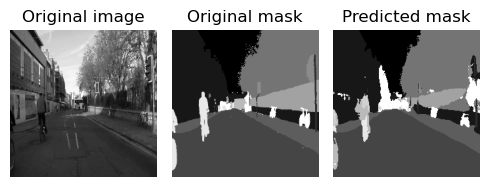

In [65]:
for i, batch in enumerate(val_dl):
    if i == 83:  # 4th sample ( indexing starts at 0)
        im, mask = batch
        break
model.eval()
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])